https://www.tensorflow.org/guide/data, well down the page

In [3]:
import tensorflow as tf

In [4]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

In [3]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

30874/30874 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

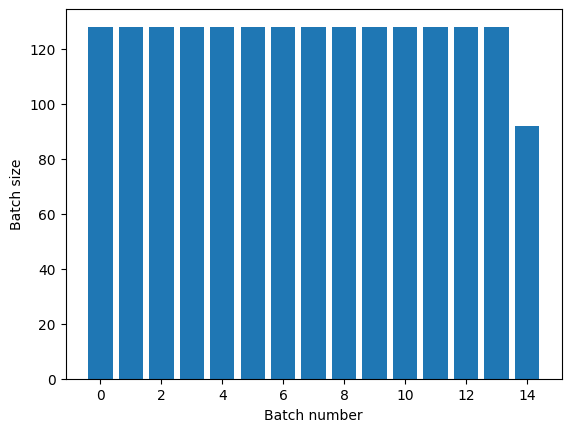

In [5]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

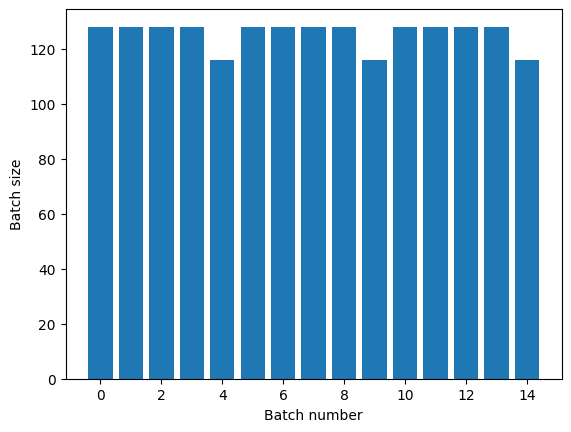

In [6]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

In [7]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


In [8]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [9]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 82   2  28  23  29  59 105  14  60  63  16  53  69  89 112  22  94  66
  40  80]


In [10]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[551 327 545 612 624 604 593 506 559 519]
[579 503 588 453 568 156 617 625 608 600]
[512 572 597 242 614 494 627 158]
[ 1 96 79 48 50  2 47 32 24 38]
[ 7 30  9 66 34 33  0 98 89 71]


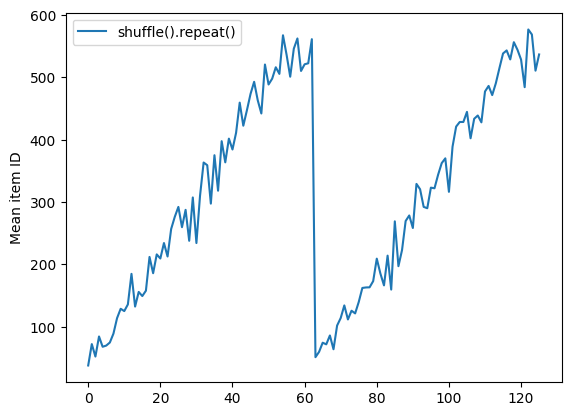

In [11]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [12]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[414 470   1 289 413 393 608 617 615  24]
[551  22 247 604   4  36 461  28 595   0]
[600 491 618 592  11 516  41 579 324 583]
[ 45 398 620 627  30  18 505 532  20  12]
[ 37 586 430  39  64  46 606 523  27 587]
[626 594  43 314  59   7 601  17 585 557]
[ 32  72  65  15  53  26 607 554 567 447]
[476 495  55  42  95  75  60  81  67 322]
[ 62   9  48 614  92 510  70 530  44  54]
[511 463 102  57  74  14 108  80 100  51]
[584 546   5 515 609 622 499  97 110 130]
[555  90 124 123 115 107 372  91 611  35]
[ 68 625  47  87 126 597 518 133 120 121]
[145   3  82 149   6 154  79 153 541 103]
[ 49  84 119 576  21 125  93 164 512 118]


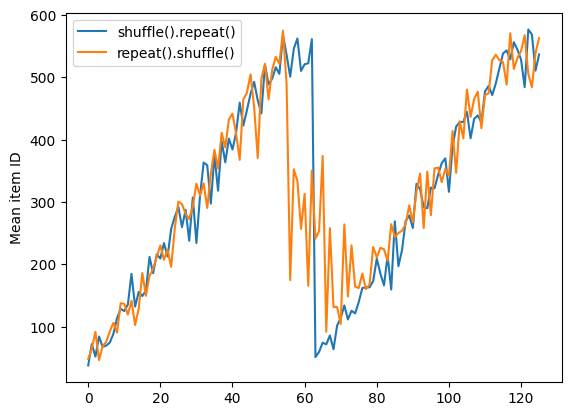

In [13]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

In [15]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [16]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [17]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

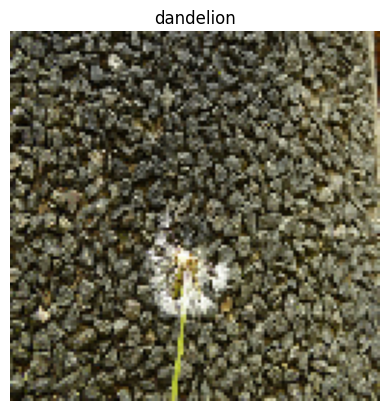

In [18]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

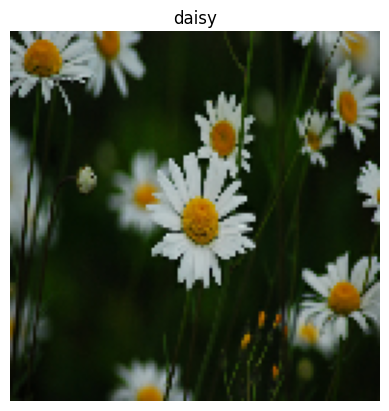

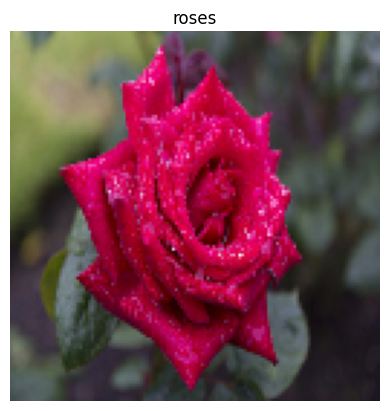

In [19]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

In [20]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

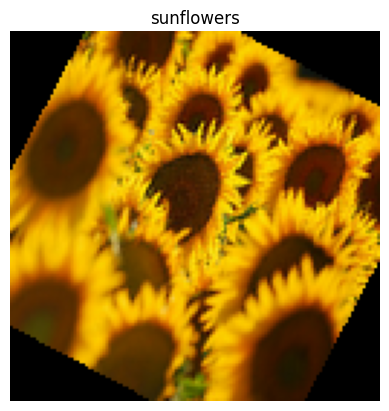

In [21]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [22]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  image = random_rotate_image(image)
  image.set_shape(im_shape)
  return image, label

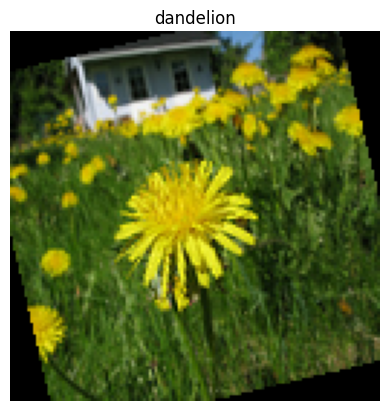

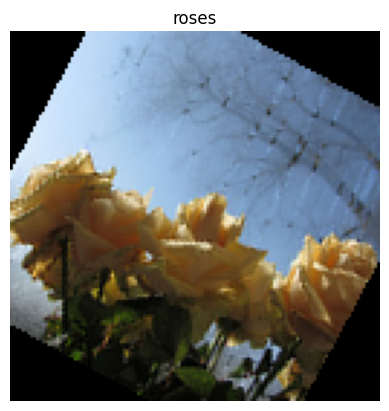

In [23]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

In [24]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

7904079/7904079 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

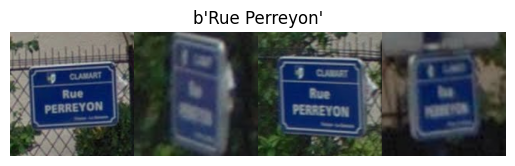

In [25]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [26]:
raw_example = next(iter(dataset))

In [27]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [28]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [29]:
decoded = dataset.map(tf_parse)
decoded

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [30]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

Time Seriews Windowing

In [5]:
range_ds = tf.data.Dataset.range(100000)

In [6]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


In [7]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


In [8]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Inputs: All except the last 5 steps
          batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


In [9]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


In [10]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [11]:
for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In [12]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


In [13]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [14]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


In [ ]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())